# Курсовая работа
***

# Моделирование роста монокристаллического твердого раствора $Al_xGa_{1-x}N$ методом хлоридной эпитаксии


In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.linalg
import sympy as sm
from tqdm import tqdm
from ggplot import *
import matplotlib.pyplot as plt
import matplotlib
from itertools import product
from pylab import rcParams

# Для тестов
def is_close(a, b, rel_tol=1e-06, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

/home/natalya/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/natalya/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/natalya/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Данные

In [2]:
row_data = pd.read_csv('q.csv', sep=';', 
                       index_col=False, 
                       names=["", "Phase", "T1", "T2", "H", 
                              "f1", "f2", "f3", "f4", "f5", "f6", "f7", 
                              "mu", "sigma", "epsil", "Comment"])
row_data.set_index('', inplace = True)
row_data.head()

,Phase,T1,T2,H,f1,f2,f3,f4,f5,f6,f7,mu,sigma,epsil,Comment
,,,,,,,,,,,,,,,
AlCl,g,298.15,3000.0,-51032.0,318.9948,36.946260,-0.001226,1.188174,5.638541,-5.066135,5.219347,62.4345,3.580,932.0,"1,2"
AlCl2,g,298.15,3000.0,-259000.0,427.2137,56.564090,-0.002961,1.893842,12.400720,-22.654410,21.298980,97.8875,5.300,825.0,"1,2,55"
AlCl3,g,298.15,3000.0,-584100.0,511.8114,81.150420,-0.004835,2.752097,13.400780,-21.280010,16.928680,133.3405,5.130,472.0,"1,2"
GaCl,g,298.15,3000.0,-70553.0,332.2718,37.110520,-0.000746,1.160651,4.891346,-4.467591,5.506236,105.1730,3.696,348.2,1
GaCl2,g,298.15,3000.0,-241238.0,443.2976,57.745845,-0.002265,1.875554,3.661860,-9.356338,15.882450,140.6260,4.293,465.0,1


#### Константы

In [3]:
R = 8.314 # Дж/(моль*К)
Pa = 100000 # атмосферное давление

#### Распределение веществ по твердым, жидким и газообазным

In [4]:
solid = {'Al', 'AlN', 'GaN'}
liquid = {'Ga'}
gas = {'AlCl', 'AlCl2', 'AlCl3', 'GaCl', 'GaCl2', 'GaCl3', 'NH3', 'H2', 'HCl', 'N2'}


#### Рассчетные функции

In [7]:
""" Коэффициенты диффузии (м2/сек) для газообразных компонент
ind - 'AlCl', 'GaN, ... 
t - температура в К
p - полное давление в системе
"""
def calcDGas(ind, t, p):
    assert (ind in gas), "This function could caclulate D only for gaseous substance"
    
    numerator = 2.628 * 10**(-2) * t**(3/2)
    
    d_ind = row_data.loc[ind]
    d_N2 = row_data.loc['N2']
    
    sigma = (d_ind.sigma + d_N2.sigma) / 2
    epsil = (d_ind.epsil * d_N2.epsil)**(1/2)
    mu = (2 * d_ind.mu * d_N2.mu) / (d_ind.mu + d_N2.mu)
    omega = 1.074 * (t / epsil)**(-0.1604)
    
    return numerator / (p * omega * mu**(1/2))

"""
Φ для расчета энергии Гиббса
ind - 'AlCl', 'GaN, ... 
t - температура в К
"""
def calcPhi(ind, t):
    data = row_data.loc[ind]
    x = t / 10**4
    
    return  (data.f1 + data.f2 * np.log(x) + 
            data.f3 / x**2 + data.f4 / x + 
            data.f5 * x + data.f6 * x**2 + 
            data.f7 * x**3)


"""
Энергия Гиббса
ind - 'AlCl', 'GaN, ... 
t - температура в К
"""
def calcG(ind, t):
    data = row_data.loc[ind]
    return data.H - calcPhi(ind, t) * t

### Рассчет K

In [8]:
def calcK1(t):
    deltaG1 = 2 * calcG('Al', t) + 2 * calcG('HCl', t) - 2 * calcG('AlCl', t) - calcG('H2', t)
    return np.exp(-deltaG1 / (R * t)) / Pa


def calcK2(t):
    deltaG2 = calcG('Al', t) + 2 * calcG('HCl', t) - calcG('AlCl2', t) - calcG('H2', t)
    return np.exp(-deltaG2 / (R * t))


def calcK3(t):
    deltaG3 = calcG('Al', t) - 2 * calcG('AlCl3', t) - 3 * calcG('H2', t) + 6 * calcG('HCl', t)
    return np.exp(-deltaG3 / (R * t)) * Pa

print("K1 = ", calcK1(100))
print("K2 = ", calcK2(100))
print("K3 = ", calcK3(100))

K1 =  2.27702386893e+30
K2 =  6.3155395805e-40
K3 =  4.80309849033e-309


# Первое задание

In [9]:
def newton_solve(system, jacobian, variables, epsilon=1e-9):
    x = np.random.uniform(0.1, 1., len(variables)).tolist()
    delta = 1
    nstep = 0
    while np.linalg.norm(delta) > epsilon:
        delta = sp.linalg.lu_solve(sp.linalg.lu_factor(jacobian(*x)), -system(*x))
        x = delta.flatten() + x
        nstep += 1
    # evaluate error: residual sum of absulute values F(x)
    rsa = np.abs(system(*x.tolist())).sum()
    return x, rsa, nstep

In [10]:
"""
Парциальные давления компонент вне диффузионного пограничного слоя (Па)
PS Даны в условии поэтому дефайним только для этого задания
ind - 'AlCl', 'GaN, ... 
"""
def first_calcPg(ind):
    if ind == 'AlCl' or ind == 'AlCl2' or ind == 'AlCl3' or ind == 'H2':
        return 0
    if ind == 'HCl':
        return 10000
    if ind == 'N2':
        return 90000
    raise Exception('Unexpected substance: ' + ind)

    
def first_make_system(pg_HCl=10000.0, p=100000, T=(350.0 + 273.0)):
    p_AlCl, p_AlCl2, p_AlCl3, p_HCl, p_H2 = first_variables = sm.symbols('p_AlCl, p_AlCl2, p_AlCl3, p_HCl, p_H2')
    k1 = calcK1(T)
    k2 = calcK2(T)
    k3 = calcK3(T)
    d_HCl = calcDGas('HCl', T, p)
    d_H2 = calcDGas('H2', T, p)
    d_AlCl = calcDGas('AlCl', T, p)
    d_AlCl2 = calcDGas('AlCl2', T, p)
    d_AlCl3 = calcDGas('AlCl3', T, p)
    equations = []
    equations.append(p_HCl ** 2 - k1 * p_AlCl ** 2 * p_H2)
    equations.append(p_HCl ** 2 - k2 * p_AlCl2 * p_H2)
    equations.append(p_HCl ** 6 - k3 * p_AlCl3 ** 2 * p_H2 ** 3)
    equations.append(d_HCl * (p_HCl - pg_HCl) + 2 * d_H2 * p_H2)
    equations.append(d_AlCl  * p_AlCl  + 
                 2 * d_AlCl2 * p_AlCl2 + 
                 3 * d_AlCl3 * p_AlCl3 + 
                     d_HCl * (p_HCl - pg_HCl))
    system = sm.Matrix(equations)
    jacobian = system.jacobian(first_variables)
    system = sm.lambdify(first_variables, system)
    jacobian = sm.lambdify(first_variables, jacobian)
    return system, jacobian, first_variables

print('One of solutions:')
system, jacobian, first_variables = first_make_system(T=350 + 273)
dict(zip(first_variables, newton_solve(system, jacobian, first_variables)[0]))

One of solutions:


{p_AlCl: 0.0038036484966620389,
 p_AlCl2: 0.00015128460027242742,
 p_AlCl3: 4379.4231702500401,
 p_HCl: 0.00012849357613751129,
 p_H2: 1516.5792358713466}

In [11]:
# benchmark
Ts = np.linspace(350, 650, 60) + 273
nruns = 1
sigma = 0.01
p = first_calcPg('HCl') + first_calcPg('N2')
first_newton_benchmark = pd.DataFrame(columns=['T_', 'G_AlCl', 'G_AlCl2', 'G_AlCl3', 
                                         'rsa', 'rsa_std', 'nstep', 'nstep_std'])
targets = ['AlCl', 'AlCl2', 'AlCl3']
for k, T in tqdm(list(enumerate(Ts))):
    sols = np.zeros((nruns, 5))
    rsa = np.zeros(nruns)
    nstep = np.zeros(nruns)
    for i in range(nruns):
        system, jacobian, first_variables = first_make_system(T=T)
        sols[i], rsa[i], nstep[i] = newton_solve(system, jacobian, first_variables)
    sol_std = sols.std(0)
    solution = sols.mean(0)
    rsa_std = rsa.std()
    rsa = rsa.mean()
    nstep_std = nstep.std()
    nstep = nstep.mean()
    # G_i
    G = {}
    Pe = dict(zip(map(str, first_variables), solution))
    for Gas in targets:
        G[Gas] = calcDGas(Gas, T, p) * (first_calcPg(Gas) - Pe['p_' + Gas]) / (R * T * sigma)
    pho = 2712.0
    mu = row_data.loc['Al'].mu
    first_newton_benchmark.loc[k] = {
        'T_': T,
        'G_AlCl': G['AlCl'],
        'G_AlCl2': G['AlCl2'],
        'G_AlCl3': G['AlCl3'],
        'rsa': rsa,
        'rsa_std': rsa_std,
        'nstep': nstep,
        'nstep_std': nstep_std
    }

100%|██████████| 60/60 [00:02<00:00, 21.72it/s]


In [12]:
first_newton_benchmark['invT'] = 1 / first_newton_benchmark.T_
first_newton_benchmark['G_AlCl_log'] = np.log(np.abs(first_newton_benchmark.G_AlCl))
first_newton_benchmark['G_AlCl2_log'] = np.log(np.abs(first_newton_benchmark.G_AlCl2))
first_newton_benchmark['G_AlCl3_log'] = np.log(np.abs(first_newton_benchmark.G_AlCl3))
first_newton_df = pd.melt(first_newton_benchmark[['invT', 'G_AlCl_log', 
                                      'G_AlCl2_log', 'G_AlCl2_log', 'G_AlCl3_log']], id_vars=['invT'])

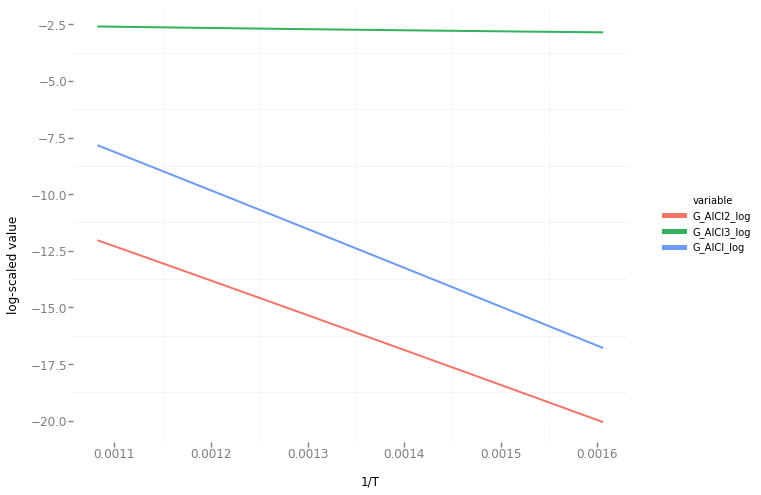

<ggplot: (-9223363286103877011)>

In [13]:
rcParams['figure.figsize'] = 10, 7
(ggplot(aes(x = 'invT', y = 'value', color='variable'), first_newton_df) + 
    geom_line(size=2) + 
    ylab('log-scaled value') + 
    xlab('1/T') + theme_bw())

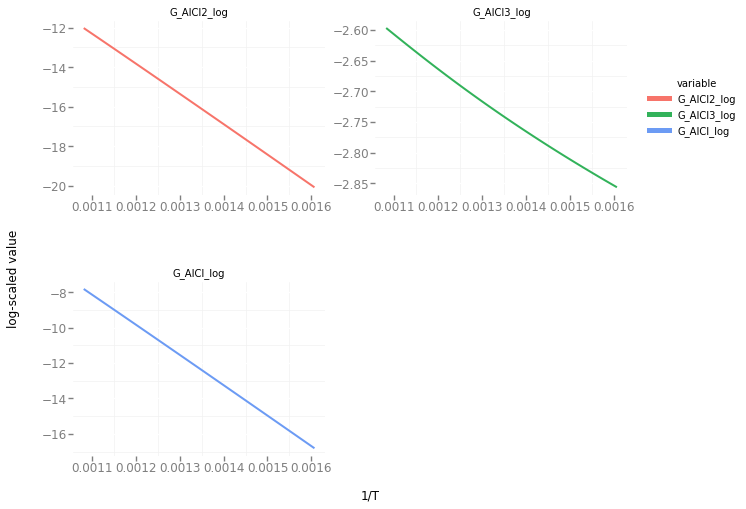

<ggplot: (8750750898892)>

In [14]:
rcParams['figure.figsize'] = 12, 7
(ggplot(aes(x = 'invT', y = 'value', color='variable'), first_newton_df) + 
    geom_line(size=2) + 
    ylab('log-scaled value') + 
    xlab('1/T') + theme_bw() + facet_wrap('variable', scales='free'))

# Второе задание

####  Рассчет K

In [15]:
def calcK4(t):
    deltaG4 = calcG('Ga', t) + 2 * calcG('HCl', t) - 2 * calcG('GaCl', t) - calcG('H2', t)
    return np.exp(-deltaG4 / (R * t)) / Pa


def calcK5(t):
    deltaG5 = calcG('GaCl2', t) + calcG('H2', t) - 2 * calcG('HCl', t) - calcG('Ga', t)
    return np.exp(deltaG5 / (R * t))


def calcK6(t):
    deltaG6 = 2 * calcG('GaCl3', t) + 3 * calcG('H2', t) - 6 * calcG('HCl', t) - 2 * calcG('Ga', t)
    return np.exp(deltaG6 / (R * t)) * Pa

print("K4 = ", calcK4(100))
print("K5 = ", calcK5(100))
print("K6 = ", calcK6(100))

K4 =  492253.458522
K5 =  5.19845126314e-32
K6 =  1.99523068921e-150


In [16]:
def second_calcPg(ind):
    if ind == 'GaCl' or ind == 'GaCl2' or ind == 'GaCl3' or ind == 'H2':
        return 0
    if ind == 'HCl':
        return 10**4
    if ind == 'N2':
        return 9 * 10**4
    raise Exception('Unexpected substance: ' + ind)

def second_make_system(p=100000, T=(650.0 + 273.0)):
    p_GaCl, p_GaCl2, p_GaCl3, p_HCl, p_H2 = second_variables = sm.symbols('p_GaCl, p_GaCl2, p_GaCl3, p_HCl, p_H2')
    pg_HCl = 10**4
    pg_N2 = 9 * 10**4
    k4 = calcK4(T)
    k5 = calcK5(T)
    k6 = calcK6(T)
    d_HCl = calcDGas('HCl', T, p)
    d_H2 = calcDGas('H2', T, p)
    d_GaCl = calcDGas('GaCl', T, p)
    d_GaCl2 = calcDGas('GaCl2', T, p)
    d_GaCl3 = calcDGas('GaCl3', T, p)
    equations = []
    equations.append(p_HCl ** 2 - k4 * p_GaCl ** 2 * p_H2)
    equations.append(p_HCl ** 2 - k5 * p_GaCl2 * p_H2)
    equations.append(p_HCl ** 6 - k6 * p_GaCl3 ** 2 * p_H2 ** 3)
    equations.append(d_HCl * (p_HCl - pg_HCl) + 2 * d_H2 * p_H2)
    equations.append(d_GaCl  * p_GaCl  + 
                 2 * d_GaCl2 * p_GaCl2 + 
                 3 * d_GaCl3 * p_GaCl3 + 
                     d_HCl * (p_HCl - pg_HCl))
    system = sm.Matrix(equations)
    jacobian = system.jacobian(second_variables)
    system = sm.lambdify(second_variables, system)
    jacobian = sm.lambdify(second_variables, jacobian)
    return system, jacobian, second_variables

print('One of solutions:')
system, jacobian, second_variables = second_make_system(T=650.0 + 273)
dict(zip(second_variables, newton_solve(system, jacobian, second_variables)[0]))

One of solutions:


{p_GaCl: 12532.988039160517,
 p_GaCl2: 0.11747869230535114,
 p_GaCl3: -1.1407623429359012e-05,
 p_HCl: 0.26069535783692055,
 p_H2: 1516.5397188412403}

In [17]:
# benchmark
# Ts = np.linspace(650, 950, 60) + 273
nruns = 1
sigma = 0.01
p = second_calcPg('HCl') + second_calcPg('N2')
second_newton_benchmark = pd.DataFrame(columns=['T_', 'V_Ga', 'G_GaCl', 'G_GaCl2', 'G_GaCl3', 
                                             'rsa', 'rsa_std', 'nstep', 'nstep_std'])
targets = ['GaCl', 'GaCl2', 'GaCl3']
for k, T in tqdm(list(enumerate(Ts))):
    sols = np.zeros((nruns, 5))
    rsa = np.zeros(nruns)
    nstep = np.zeros(nruns)
    for i in range(nruns):
        system, jacobian, second_variables = second_make_system(T=T)
        sols[i], rsa[i], nstep[i] = newton_solve(system, jacobian, second_variables, epsilon=1e-9)
    sol_std = sols.std(0)
    solution = sols.mean(0)
    rsa_std = rsa.std()
    rsa = rsa.mean()
    nstep_std = nstep.std()
    nstep = nstep.mean()
    # G_i
    G = {}
    Pe = dict(zip(map(str, second_variables), solution))
    for Gas in targets:
        G[Gas] = calcDGas(Gas, T, p) * (second_calcPg(Gas) - Pe['p_' + Gas]) / (R * T * sigma)
    pho = 5900.
    mu = row_data.loc['Ga'].mu
    V = (G['GaCl'] + G['GaCl2'] + G['GaCl3']) * (mu / pho) * 1e9
    second_newton_benchmark.loc[k] = {
        'T_': T,
        'V_Ga': V,
        'G_GaCl': G['GaCl'],
        'G_GaCl2': G['GaCl2'],
        'G_GaCl3': G['GaCl3'],
        'rsa': rsa,
        'rsa_std': rsa_std,
        'nstep': nstep,
        'nstep_std': nstep_std
    }

100%|██████████| 60/60 [00:02<00:00, 22.14it/s]


In [18]:
second_newton_benchmark['invT'] = 1 / second_newton_benchmark.T_
second_newton_benchmark['V_Ga_log'] = np.log(np.abs(second_newton_benchmark.V_Ga))

second_newton_benchmark['G_GaCl_log'] = np.log(np.abs(second_newton_benchmark.G_GaCl))
second_newton_benchmark['G_GaCl2_log'] = np.log(np.abs(second_newton_benchmark.G_GaCl2))
second_newton_benchmark['G_GaCl3_log'] = np.log(np.abs(second_newton_benchmark.G_GaCl3))
second_newton_df = pd.melt(second_newton_benchmark[['invT', 'V_Ga_log', 'G_GaCl_log', 
                                      'G_GaCl2_log', 'G_GaCl2_log', 'G_GaCl3_log']], id_vars=['invT'])

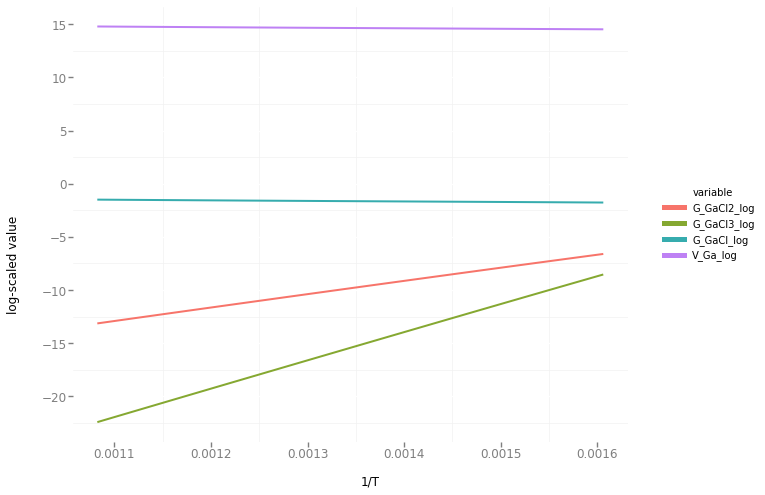

<ggplot: (8750749631580)>

In [19]:
rcParams['figure.figsize'] = 10, 7
(ggplot(aes(x = 'invT', y = 'value', color='variable'), second_newton_df) + 
    geom_line(size=2) + 
    ylab('log-scaled value') + 
    xlab('1/T') + 
    theme_bw())

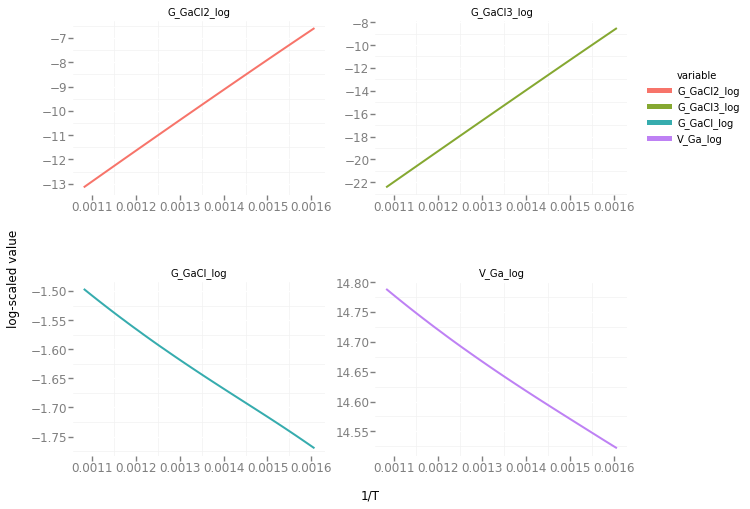

<ggplot: (8750749465373)>

In [20]:
rcParams['figure.figsize'] = 12, 7
(ggplot(aes(x = 'invT', y = 'value', color='variable'), second_newton_df) + 
    geom_line(size=2) + 
    ylab('log-scaled value') + 
    xlab('1/T') +
    theme_bw() + 
    facet_wrap('variable', scales='free'))

## Третье задание

#### Рассчет K

In [21]:
def calcK9(t):
    deltaG9 = calcG('AlCl3', t) + calcG('NH3', t) - calcG('AlN', t) - 3 * calcG('HCl', t)
    return np.exp(-deltaG9 / (R * t)) / Pa


def calcK10(t):
    deltaG10 = calcG('GaCl', t) + calcG('NH3', t) - calcG('HCl', t) - calcG('H2', t) - calcG('GaN', t)
    return np.exp(-deltaG10 / (R * t))




print("K9 = ", calcK9(100))
print("K10 = ", calcK10(100))

K9 =  86699219.3922
K10 =  5.44646362935e-44


In [22]:
def third_make_system(xg, case='clean N2'):
    """
    xg: in [0, 1]
    case: 1 - clean N2
          2 - 10% mix of H2 and N2
    """
    p_AlCl3, p_GaCl, p_NH3, p_HCl, p_H2, x = variables = sm.symbols('p_AlCl3, p_GaCl, p_NH3, p_HCl, p_H2, x')
    T = 1100 + 273
    p_atm = 100000
    p_AlGa = 30
    pg_NH3 = 1500
    pg_HCl = 0
    if case == 'clean N2':
        pg_H2 = 0
        pg_N2 = 98470
    elif case == '10% mix of H2 and N2':
        pg_H2 = 9847
        pg_N2 = 88623
    pg_AlCl3 = xg * p_AlGa
    pg_GaCl = (1 - xg) * p_AlGa
    k9 = calcK9(T)
    k10 = calcK10(T)
    d_HCl = calcDGas('HCl', T, p_atm)
    d_H2 = calcDGas('H2', T, p_atm)
    d_NH3 = calcDGas('NH3', T, p_atm)
    d_AlCl3 = calcDGas('AlCl3', T, p_atm)
    d_GaCl = calcDGas('GaCl', T, p_atm)
    d_HCl = calcDGas('HCl', T, p_atm)
    equations = []
    equations.append(p_AlCl3 * p_NH3 - k9  * x * p_HCl ** 3)
    equations.append(p_GaCl  * p_NH3 - k10 * (1 - x) * p_HCl * p_H2)
    equations.append(d_HCl * (pg_HCl - p_HCl) +
                 2 * d_H2  * (pg_H2  - p_H2 ) +
                 3 * d_NH3 * (pg_NH3 - p_NH3))
    equations.append(3 * d_AlCl3 * (pg_AlCl3 - p_AlCl3) +
                         d_GaCl  * (pg_GaCl  - p_GaCl ) +
                         d_HCl   * (pg_HCl   - p_HCl  ))
    equations.append(d_AlCl3 * (pg_AlCl3 - p_AlCl3) +
                     d_GaCl  * (pg_GaCl  - p_GaCl)  -
                     d_NH3   * (pg_NH3   - p_NH3))
    equations.append(d_AlCl3 * (pg_AlCl3 - p_AlCl3) * (1 - x) -
                     d_GaCl  * (pg_GaCl  - p_GaCl)  * x)
    system = sm.Matrix(equations)
    jacobian = system.jacobian(variables)
    system = sm.lambdify(variables, system)
    jacobian = sm.lambdify(variables, jacobian)
    return system, jacobian, variables

In [23]:
print('One of solutions:')
system, jacobian, variables = third_make_system(0.5)
s = newton_solve(system, jacobian, variables)
dict(zip(variables, s[0]))

One of solutions:


{p_AlCl3: 4.1979740199008028e-07,
 p_GaCl: 0.034176403459167282,
 p_NH3: 1479.9833967834718,
 p_HCl: 46.191695201399888,
 p_H2: 3.6217797931392508,
 x: 0.48879174252738827}

In [24]:
system(*s[0])

array([[  2.16840434e-19],
       [  0.00000000e+00],
       [ -8.32667268e-17],
       [  0.00000000e+00],
       [ -3.61730502e-16],
       [  0.00000000e+00]])

In [25]:
# benchmark
xgs = np.linspace(0., 1., 60)
cases = ['clean N2', '10% mix of H2 and N2']
nruns = 1
sigma = 0.01
p = 100000
T = 1100 + 273
third_newton_benchmark = pd.DataFrame(columns=['xg', 'case', 'x', 'V_AlGaN', 'G_GaCl', 'G_AlCl3'])
targets = ['GaCl', 'AlCl3']
for k, (xg, case) in tqdm(list(enumerate(product(xgs, cases)))):
    sols = np.zeros((nruns, 6))
    rsa = np.zeros(nruns)
    nstep = np.zeros(nruns)
    for i in range(nruns):
        x = 2
        while x < 0 or x > 1:
            system, jacobian, variables = third_make_system(xg, case)
            sols[i], rsa[i], nstep[i] = newton_solve(system, jacobian, variables, epsilon=1e-8)
            x = sols[i][-1]
    sol_std = sols.std(0)
    solution = sols.mean(0)
    rsa_std = rsa.std()
    rsa = rsa.mean()
    nstep_std = nstep.std()
    nstep = nstep.mean()
    # G_i
    G = {}
    p_AlGa = 30
    Pg = {
        'GaCl': (1 - xg) * p_AlGa,
        'AlCl3': xg * p_AlGa 
    }
    Pe = dict(zip(map(str, variables), solution))
    for Gas in targets:
        G[Gas] = calcDGas(Gas, T, p) * (Pg[Gas] - Pe['p_' + Gas]) / (R * T * sigma)
    rho_AlN = 3200.
    rho_GaN = 6150.
    mu_AlN = row_data.loc['AlN'].mu
    mu_GaN = row_data.loc['GaN'].mu
    V = (G['AlCl3'] * (mu_AlN / rho_AlN) + G['GaCl'] * (mu_GaN / rho_GaN)) * 1e9
    if V > 100000:
        continue
    third_newton_benchmark.loc[k] = {
        'xg': xg,
        'case': case,
        'x': Pe['x'],
        'V_AlGaN': V,
        'G_GaCl': G['GaCl'],
        'G_AlCl3': G['AlCl3'],
    }

100%|██████████| 120/120 [00:14<00:00,  8.36it/s]


In [26]:
third = pd.melt(third_newton_benchmark, id_vars=['xg', 'case'])

In [27]:
third.case = third.case.map(str)

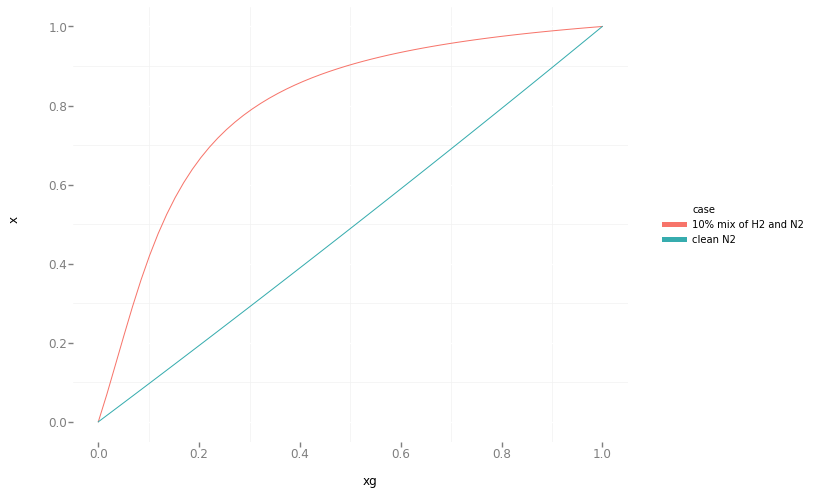

<ggplot: (8750749320256)>

In [28]:
(ggplot(aes(y='value', x='xg', color='case'), data=third[third.variable == 'x']) + theme_bw() + 
     geom_line() + ylab('x'))